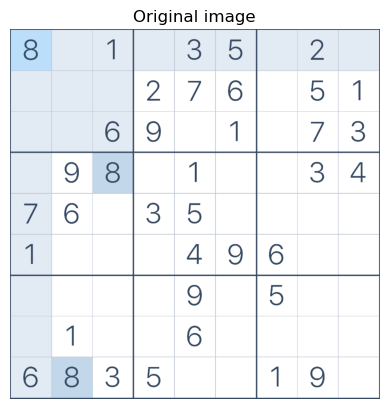

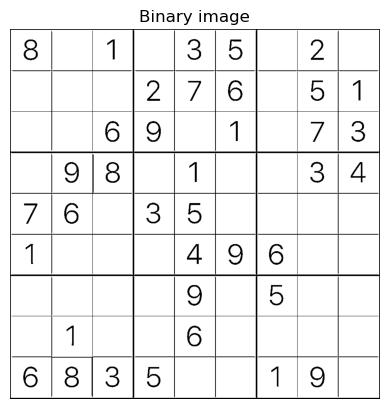

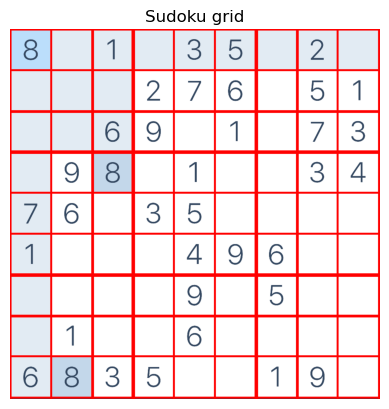

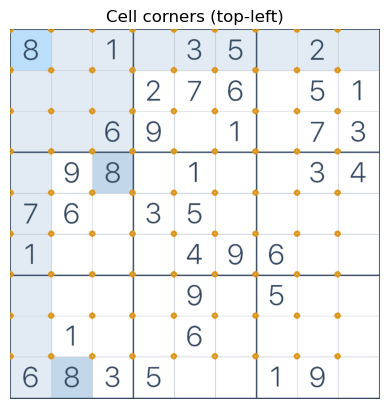

8 _ 1 _ 3 5 _ 2 _
_ _ _ 2 7 6 _ 5 1
_ _ 6 9 _ 1 _ 7 3
_ 9 8 _ 1 _ _ 3 4
7 6 _ 3 5 _ _ _ _
1 _ _ _ 4 9 6 _ _
_ _ _ _ 9 _ 5 _ _
_ 1 _ _ 6 _ _ _ _
6 8 3 5 _ _ 1 9 _


In [3]:
import sys, cv2
import numpy as np
import matplotlib.pyplot as plt

##### Functions #####
def show_image(img, title='Image', cmap_type='gray'):
    plt.imshow(img, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

def get_line_coordinates(rho, theta, dim):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + dim * (-b))
    y1 = int(y0 + dim * (a))
    x2 = int(x0 - dim * (-b))
    y2 = int(y0 - dim * (a))
    return x1, y1, x2, y2


def check_point_similarity(point1, point2, size):
    x_diff = abs(point1[0] - point2[0])
    y_diff = abs(point1[1] - point2[1])    
    return x_diff <= size//20 and y_diff <= size//20


##### Main program #####
image_path = "images/standard.png"
template_path = "templates/"

### Step 1: Preprocessing
try:
    # Load the image
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply thresholding to get a binary image
    primg = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    show_image(img, title="Original image")
    show_image(primg, title="Binary image")

except Exception as e:
    print("Input error: ", e)
    sys.exit(1)


### Step 2: Detecting the Sudoku Grid
try:
    # Edge detection
    high_threshold, _ = cv2.threshold(primg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_threshold = 0.5*high_threshold
    edges = cv2.Canny(primg, low_threshold, high_threshold)
    # Detect lines using Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    # Display the lines visually
    diagonal_dim = int(np.sqrt(img.shape[0]**2 + img.shape[1]**2))
    grid = img.copy()
    for rho, theta in lines[:,0]:
        x1, y1, x2, y2 = get_line_coordinates(rho, theta, diagonal_dim)
        cv2.line(grid, (x1, y1), (x2, y2), (255, 0, 0), 3)
    show_image(grid, title="Sudoku grid")

    ### Step 3: Finding the coordinates of the cells
    horizontal_lines = []
    vertical_lines = []
    # Threshold to consider lines as horizontal or vertical (10 degrees tolerance)
    angle_threshold = np.pi / 180 * 10  
    # Separate the detected lines into horizontal and vertical lines
    for line in lines:
        for rho, theta in line:
            if abs(theta) < angle_threshold or abs(theta - np.pi) < angle_threshold:
                horizontal_lines.append((rho, theta))
            elif abs(theta - np.pi/2) < angle_threshold:
                vertical_lines.append((rho, theta))
    # Find intersections between horizontal and vertical lines to define cell corners
    intersections_ = []
    for h_line in horizontal_lines:
        for v_line in vertical_lines:
            h_rho, h_theta = h_line
            v_rho, v_theta = v_line
            # Equations to solve for intersections
            A = np.array([
                [np.cos(h_theta), np.sin(h_theta)],
                [np.cos(v_theta), np.sin(v_theta)] ])
            b = np.array([h_rho, v_rho])
            intersection_point = np.linalg.solve(A, b)
            intersections_.append(intersection_point)
    # Sort the intersection points
    intersections_array = np.array(intersections_)
    sorted_indices = np.lexsort((intersections_array[:, 0], intersections_array[:, 1]))
    intersections = intersections_array[sorted_indices]
    # Discard any duplicate points that are close to each other
    unique_intersections = []
    for current_point in intersections:
        if not any(check_point_similarity(current_point, existing_point, np.max(intersections)) for existing_point in unique_intersections):
            # Ensure that coordinates are integers and that they are >= 0
            int_point = [int(max(0, current_point[0])), int(max(0, current_point[1]))] 
            unique_intersections.append(int_point)
    # Keep only the top-left corners
    cell_corners = []
    for c, point in enumerate(unique_intersections):
        if c+1 > 90:
            break
        if (c+1) % 10 == 0:
            continue
        cell_corners.append(point)
    for point in cell_corners:
        cv2.circle(img, tuple(map(int, point)), radius=5, color=(220, 150, 30), thickness=5)  # Green color circle
    show_image(img, title="Cell corners (top-left)")

    ### Step 4: Recognizing Numbers (template matching approach)
    # Load the templates
    templates = {}
    for digit in range(9):
        filepath = f"{template_path}{digit+1}.png"
        template = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        template = cv2.adaptiveThreshold(template, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        if template is not None:
            templates[digit+1] = template
    # Find the length of the side of a cell
    l = (cell_corners[8][0]-cell_corners[0][0])//8
    # Recognize the numbers (or that the cell is empty)
    recognized_numbers = {}
    for index, cell in enumerate(cell_corners):
        x = cell[0]
        y = cell[1]
        cell_img = primg[y:y+l, x:x+l]
        max_score = 0
        number = "_"  # Blank cell
        for digit, template in templates.items():
            # Apply template matching
            res = cv2.matchTemplate(cell_img, template, cv2.TM_CCOEFF_NORMED)
            # Get the confidence score
            _, max_val, _, _ = cv2.minMaxLoc(res)
            if max_val > max_score:
                max_score = max_val
                number = digit if max_val > 0.3 else "_"  # Threshold to consider as a match
        #show_image(cell_img, title=str(number)+' '+str(max_score), cmap_type='gray')       
        recognized_numbers[index] = number

except Exception as e:
    print("Elaboration error: ", e)
    sys.exit(1)


### Step 5: Output the recognized numbers
try:
    # Initialize an empty grid
    grid = [["_" for _ in range(9)] for _ in range(9)]
    # Fill the grid with recognized numbers
    for cell_index, number in recognized_numbers.items():
        row = cell_index // 9
        col = cell_index % 9
        grid[row][col] = number
        # Place the recognized number in the grid
        grid[row][col] = str(number)
    # Print the grid
    for row in grid:
        print(" ".join(row))

except Exception as e:
    print("Output error: ", e)